In [1]:
# setup and imports
import pandas as pd
import numpy as np
import pymc
from scipy.stats.distributions import binom
%pylab inline
print(pymc.__version__)  # pymc3 and 2 are *really* different. This is 2.

Populating the interactive namespace from numpy and matplotlib
3.0


p-values are Only as Good as Their Power: A Bayesian Example
------------------------------------------------------------

[Andrew Gelman](http://andrewgelman.com/2015/10/13/what-do-you-learn-from-p-05-this-example-from-carl-morris-will-blow-your-mind/) recently referenced a classic statistical example from Carl Morris, which goes like this:

Suppose candidates A and B are running in election. Historically, these races are tight, so that the winner usually has a vote total between 50 and 60%. Candidate A sponsors three polls, which give the following results:
* Poll 1 interviews 20 people and finds 75% of responses in favor of candidate A.
* Poll 2 inverviews 200 people and finds 57.5% of responses in favor of candidate A.
* Poll 3 inverviews 2000 people and finds 52.3% of responses in favor of candidate A.

A frequentist statistican would set up a null hypothesis of "B will win the election" which is equivalent to $\theta < 0.5$ where the distribution of A votes is $Bin(\theta)$. What is the p-value for each of these polls? The original paper used a t-test with continuity correction and got roughly $p = 0.021$ for each poll. We can easily do the same with explicity binomial checks:

In [5]:
print("The p-value for Poll 1 is {0}".format(1 - binom(20, .5).cdf(14)))
print("The p-value for Poll 2 is {0}".format(1 - binom(200, .5).cdf(114)))
print("The p-value for Poll 3 is {0}".format(1 - binom(2000, .5).cdf(1045)))

The p-value for Poll 1 is 0.020694732666
The p-value for Poll 1 is 0.0200185958067
The p-value for Poll 1 is 0.0209209953389


Which poll is the most favorable for candidate A? Put another way, if you were a betting woman, which poll would encourage you to bet the most?

In this post, we'll use pymc to show that poll 3 is by far the best result. Put another way, **Poll 3 with 2000 users is most consistent with an actual $\theta > 0.5$.**

Modeling the Poll in pymc
----------------------------------

The polls are very simple modeled as:
$$ \theta \sim N(0.5, 0.05) $$
$$ poll_a \sim Bin(n, n * \theta) $$

Our prior $\theta$ essentially encodes our belief that the electorate is most probably between 40 and 60% in favor of candidate A, and it encodes no bias towards either candidate. Each poll is a Binomially distributed variable assuming a $\theta$ fraction of successes in $n$ draws where $n$ will be 20, 200, or 2000.

In [2]:
#
# Build the model in pymc2. Note that tau is the inverse of $sigma$. Also, note that outcome is observed.
# Use 10000 samples from an MCMC with a 100 iteration burnin. Our model is very simple, so I'm not overly
# concerned about a poor fit.
#
num_samples = 10000
burnin = 100
def build_and_run_model(n, pobs):

    theta = pymc.Normal("theta", mu=.5, tau=1/(.05**2))
    outcome = pymc.Binomial("outcome", n=n, p=theta, value=pobs, observed=True)

    @pymc.deterministic
    def a_wins(theta=theta):
        return theta > .5
    
    m = pymc.MCMC([theta, outcome, a_wins])
    m.sample(num_samples + burnin, burn=burnin)
    return m.trace


In [61]:
possible_n = [20, 200, 2000]
stated_outcomes = [.75, .575, .523]
results = {}  # We'll store model traces here.

for n, pobs in zip(possible_n, stated_outcomes):
    traces_key = "{0} obs with {1} for A".format(n, pobs)
    results[traces_key] = build_and_run_model(n, pobs * n)


 [-----------------100%-----------------] 10100 of 10100 complete in 1.1 sec

In [62]:
# Results is a dictionary of traces
results

{'20 obs with 0.75 for A': <bound method MCMC.trace of <pymc.MCMC.MCMC object at 0x000000000E5CC7B8>>,
 '200 obs with 0.575 for A': <bound method MCMC.trace of <pymc.MCMC.MCMC object at 0x000000000E0F2128>>,
 '2000 obs with 0.523 for A': <bound method MCMC.trace of <pymc.MCMC.MCMC object at 0x000000000E0840B8>>}

Q1: What is prob of null hypothesis of $\theta < .5$ in each situation?

In [63]:
print("Prob of null hypothesis")
for k, v in results.items():
    chance_a_wins = 1 - sum(v('a_wins')[:]) / num_samples
    print("{0}: {1}".format(k, chance_a_wins))

Prob of null hypothesis
2000 obs with 0.523 for A: 0.01870000000000005
200 obs with 0.575 for A: 0.05249999999999999
20 obs with 0.75 for A: 0.14949999999999997


Visualizing those results

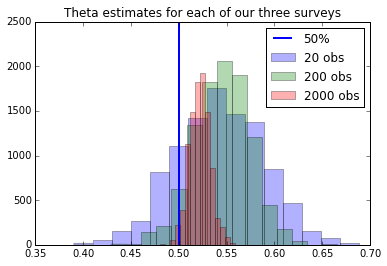

In [6]:
hist(results['20 obs with 0.75 for A']('theta')[:], bins=15, alpha=.3)
hist(results['200 obs with 0.575 for A']('theta')[:], bins=15, alpha=.3)
hist(results['2000 obs with 0.523 for A']('theta')[:], bins=15, alpha=.3)
axvline(.5, linewidth=2)
_=legend(["50%", "20 obs", "200 obs", "2000 obs"])
title("Theta estimates for each of our three surveys")

Modeling the prior $\theta$ under each outcome shows that the larger sample sizes lead to much tighter estimates of the actual population. Most importantly for candidate A, the amount of weight on the low side of 0.5 gets much smaller: the probability of A losing given the observation in the 2000-person sample is much lower than the probability of A losing under the 20-person sample.

Another way to examine the three observations is to compute the **Bayes Factor**, which is defined as the ratio of probabilities of the data given two models:

$$BF(D, M_1, M_2) = \frac{P(D|M_1)}{P(D|M_2)}$$

We can actually estimate a Bayes factor relatively easily. The idea is to create an unconstrained model of the system and then compare probability of observing a given score under two models corresponding to a model where $\theta < .5$ and a model where $\theta > .5$. In other words, we assume a model where A wins and assume a model where A wins. The distribution of $\theta$ in these two models is given by the plot below.

In [114]:
def build_and_run_model_unobs(n):

    theta = pymc.Normal("theta", mu=.5, tau=1/(.05**2))
    outcome = pymc.Binomial("outcome", n=n, p=theta)

    @pymc.deterministic
    def a_wins(theta=theta):
        return theta > .5
    
    m = pymc.MCMC([theta, outcome, a_wins])
    m.sample(num_samples + burnin, burn=burnin)
    return m.trace

 [-----------------100%-----------------] 10100 of 10100 complete in 1.3 sec

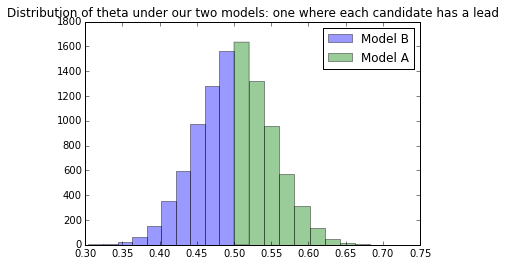

In [78]:
model_null = build_and_run_model_unobs(20)
thetas = model_null('theta')[:]
null_true = thetas < .5
hist(thetas[null_true], alpha=.4)
hist(thetas[~null_true], alpha=.4)
legend(["Model B", "Model A"])
title("Distribution of theta under our two models: one where each candidate has a lead")

The probability of observing $75\%$ in favor of A under each model is given by:

 [-----------------100%-----------------] 10100 of 10100 complete in 1.4 sec
Bayes Factor Estimate: 5.633255365987892


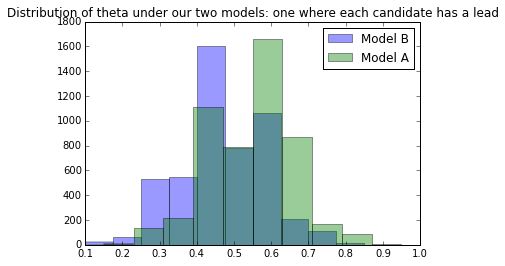

In [127]:
model_20 = build_and_run_model_unobs(20)
thetas = model_20('theta')[:]
b_true = thetas < .5

outcomes = model_20('outcome')[:]
outcome_b_true = outcomes[b_true]
outcome_a_true = outcomes[~b_true]
bf = (sum(outcome_a_true >= 15) / outcome_a_true.shape[0]) / (sum(outcome_b_true >= 15) / outcome_b_true.shape[0])
print()
print("Bayes Factor Estimate: {0}".format(bf))


hist(outcome_b_true / 20, alpha=.4)
hist(outcome_a_true / 20, alpha=.4)
legend(["Model B", "Model A"])
_ = title("Distribution of theta under our two models: one where each candidate has a lead")

The Bayes Factor is estimated to be roughly 4.8, which is positive for A, but not terribly large. The result suggests that A is more likely to win, sure, but there are cases where B is really in the lead but we still observe 15 of 20 votes for A. For comparison, let's compare the result to the outcome from the other tests:

 [-----------------100%-----------------] 10100 of 10100 complete in 1.3 sec
Bayes Factor Estimate: 73.84203090618124


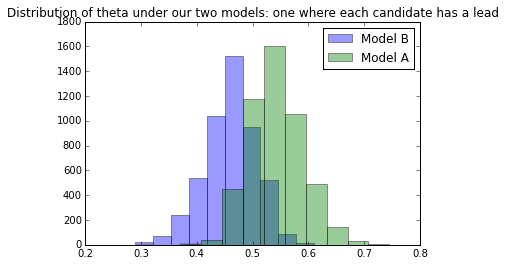

In [126]:
model_200 = build_and_run_model_unobs(200)
thetas = model_200('theta')[:]
b_true = thetas < .5

outcomes = model_200('outcome')[:]
outcome_b_true = outcomes[b_true]
outcome_a_true = outcomes[~b_true]
bf = (sum(outcome_a_true >= 200*.575) / outcome_a_true.shape[0]) / (sum(outcome_b_true >= 200*.575) / outcome_b_true.shape[0])
print()
print("Bayes Factor Estimate: {0}".format(bf))


hist(outcome_b_true / 200, alpha=.4)
hist(outcome_a_true / 200, alpha=.4)
legend(["Model B", "Model A"])
_ = title("Distribution of theta under our two models: one where each candidate has a lead")

 [-----------------100%-----------------] 10100 of 10100 complete in 1.4 sec
Bayes Factor Estimate: 273.96916036609633


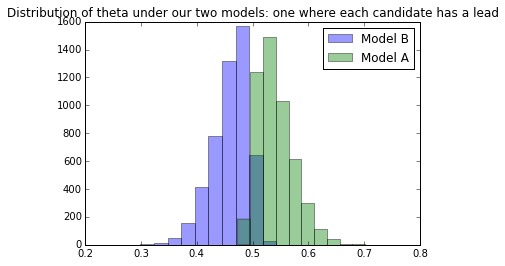

In [128]:
model_2000 = build_and_run_model_unobs(2000)
thetas = model_2000('theta')[:]
b_true = thetas < .5

outcomes = model_2000('outcome')[:]
outcome_b_true = outcomes[b_true]
outcome_a_true = outcomes[~b_true]
bf = (sum(outcome_a_true >= 2000*.523) / outcome_a_true.shape[0]) / (sum(outcome_b_true >= 2000*.523) / outcome_b_true.shape[0])
print()
print("Bayes Factor Estimate: {0}".format(bf))


hist(outcome_b_true / 2000, alpha=.4)
hist(outcome_a_true / 2000, alpha=.4)
legend(["Model B", "Model A"])
_ = title("Distribution of theta under our two models: one where each candidate has a lead")

At our sample with 2000 observations, the data is far more likely to occur under a situation where A is in the lead than B. 

Recreate the p-value claim 
-------------------------------

The original Morris article claims that all three surveys reject $H_0$ (b wins) with same p-value. Below, just for kicks, we recreate that result. In each case, we directly estimate the probability of observing a result as extreme as the survey result (or more extreme) assuming a $\theta = .5$. These are all 1-sided tests, which matches the paper. In all three cases, we get pretty close!

In [109]:
def build_and_run_model_set_theta(n):

    outcome = pymc.Binomial("outcome", n=n, p=.5)

    @pymc.deterministic
    def a_wins(theta=theta):
        return theta > .5
    
    m = pymc.MCMC([outcome, a_wins])
    m.sample(num_samples + burnin, burn=burnin)
    return m.trace

 [-----------------100%-----------------] 10100 of 10100 complete in 1.0 sec
p-value estimate: 0.0197


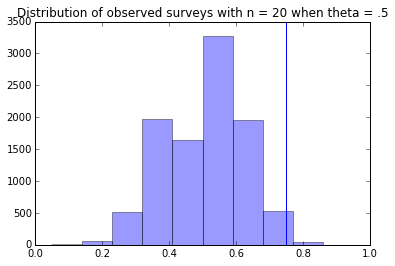

In [129]:
m = build_and_run_model_set_theta(20)
outcomes = m('outcome')[:]
print()
print("p-value estimate: {0}".format(sum(outcomes >= 15) / outcomes.shape[0]))
_ = hist(outcomes[:] / 20, alpha=.4)
axvline(.75)
_ = title("Distribution of observed surveys with n = 20 when theta = .5")


 [-----------------100%-----------------] 10100 of 10100 complete in 0.9 sec
p-value estimate: 0.0189


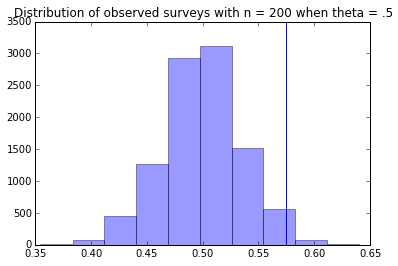

In [130]:
m = build_and_run_model_set_theta(200)
outcomes = m('outcome')[:]
print()
print("p-value estimate: {0}".format(sum(outcomes >= 200*.575) / outcomes.shape[0]))
_ = hist(outcomes[:] / 200, alpha=.4)
axvline(.575)
_ = title("Distribution of observed surveys with n = 200 when theta = .5")


 [-----------------100%-----------------] 10100 of 10100 complete in 0.8 sec
p-value estimate: 0.0204


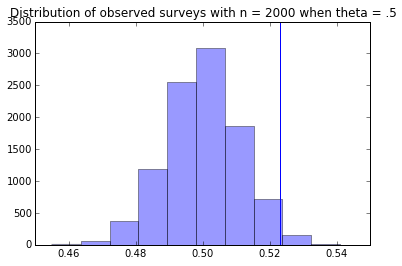

In [131]:
m = build_and_run_model_set_theta(2000)
outcomes = m('outcome')[:]
print()
print("p-value estimate: {0}".format(sum(outcomes >= 2000*.523) / outcomes.shape[0]))
_ = hist(outcomes[:] / 2000, alpha=.4)
axvline(.523)
_ = title("Distribution of observed surveys with n = 2000 when theta = .5")


But wait!
-----------

In the results above, we basically set $\theta$ to the most generous possible value under which the null hypothesis is true. (We technically set it to a value for which *neither* hypothesis is true!) What if we compute the probabiliy of observing each survey in a situation where we let $\theta$ take values from our prior? It turns out we already have the machinery for this from the earlier Bayes Factor work, so we'll reuse it here.

 [-----------------100%-----------------] 10100 of 10100 complete in 1.3 sec
Prob of stat or more extreme: 0.00986908358509567


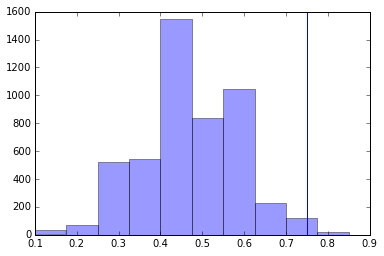

In [119]:
model_20 = build_and_run_model_unobs(20)
thetas = model_20('theta')[:]
null_true = thetas < .5

outcomes = model_20('outcome')[:]
outcome_null_true = outcomes[null_true]
pval = (sum(outcome_null_true >= 15) / outcome_null_true.shape[0])
print()
print("Prob of stat or more extreme: {0}".format(pval))

hist(outcome_null_true / 20, alpha=.4)
axvline(.75)
title("")

 [-----------------100%-----------------] 10100 of 10100 complete in 1.6 sec
Prob of stat or more extreme: 0.0032025620496397116


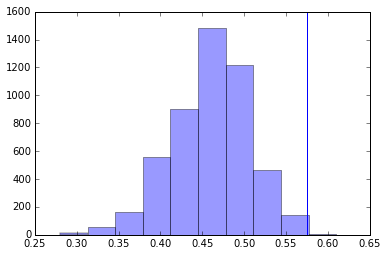

In [123]:
model_200 = build_and_run_model_unobs(200)
thetas = model_200('theta')[:]
null_true = thetas < .5

outcomes = model_200('outcome')[:]
outcome_null_true = outcomes[null_true]
pval = (sum(outcome_null_true >= 200*.575) / outcome_null_true.shape[0])
print()
print("Prob of stat or more extreme: {0}".format(pval))

hist(outcome_null_true / 200 , alpha=.4)
axvline(.575)
title("")

 [-----------------100%-----------------] 10100 of 10100 complete in 1.6 sec
Prob of stat or more extreme: 0.0006025306286402892


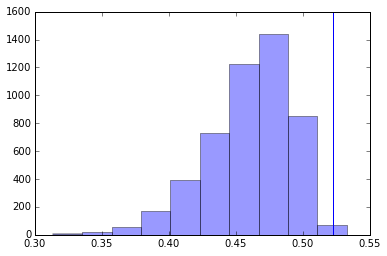

In [132]:
model_2000 = build_and_run_model_unobs(2000)
thetas = model_2000('theta')[:]
null_true = thetas < .5

outcomes = model_2000('outcome')[:]
outcome_null_true = outcomes[null_true]
pval = (sum(outcome_null_true >= 2000*.523) / outcome_null_true.shape[0])
print()
print("Prob of stat or more extreme: {0}".format(pval))

hist(outcome_null_true / 2000 , alpha=.4)
axvline(.523)
title("")

In general, all we've done is recreate Morris' original argument: survey 3 is far better even though the margin of victory was narrower: the margin of error was low enough to make the margin more important. Hopefully, plotting these numbers out makes the result even more clear.